# Analysing Farmburg Game - A/B Test 

## Data-Preprocessing

In [1]:
# Import the libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import binomtest

In [2]:
# display the results of the csv file
ab_data = pd.read_csv("./clicks.csv")
ab_data.head()

,user_id,group,is_purchase
0,8e27bf9a,A,No
1,eb89e6f0,A,No
2,7119106a,A,No
3,e53781ff,A,No
4,02d48cf1,A,Yes


In [3]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      4998 non-null   object
 1   group        4998 non-null   object
 2   is_purchase  4998 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


There doesnt seem to be any null values or incorrect data types as the `user_id` column is made of alphanumeric letters.

Note that we have two categorical variables: `group` and `is_purchase`. We are interested in whether visitors are more likely to make a purchase if they are in any one group compared to the others. Because we want to know if there is an association between two categorical variables, we’ll start by using a Chi-Square test to address our question.

In order to run a **Chi-Square test**, we first need to create a contingency table of the variables group and is_purchase.

In [4]:
df = pd.crosstab(ab_data["group"],ab_data["is_purchase"],dropna=False)
df

is_purchase,No,Yes
group,,
A,1350,316
B,1483,183
C,1583,83


In [5]:
def contingency_test():
    chi2, pval, dof, expected = chi2_contingency(df)
    return chi2, pval
chi2, pval = contingency_test()
print("The p-value of the tabulation is: {}".format(pval))

The p-value of the tabulation is: 2.412621354668426e-35


In [6]:
df["total"] = df["No"] + df["Yes"]
df["percent_purchase"] = (df["Yes"]/df["total"]).multiply(100)
df

is_purchase,No,Yes,total,percent_purchase
group,,,,
A,1350,316,1666,18.967587
B,1483,183,1666,10.984394
C,1583,83,1666,4.981993


## Univariate Anlaysis

We will need to calculate the necessary purchase rate for each price point. Let’s start by calculating the number of visitors to the site this week.

It turns out that we ran the original test over the course of a week, so the number of visitors in abdata is equal to the number of visitors in a typical week. Calculate the number of visitors in the data 

In [7]:
num_visits = len(ab_data)
def num_sales(min_value,*vals):
    # Calculate the number of visitors who need to purchase the upgraded price point.
    
    print("The number of visitors each week is {}".format(num_visits))
    
    p_sales_needed = [min_value/vals[v] for v in range(len(vals)-1)]
    
    # To calculate the proportion of visits that would need to meet the 
    # $1,000 weekly goal for a different price points.
    weekly_sales = [sales/num_visits for sales in p_sales_needed]

    return weekly_sales
# Calling the function
p_sales_needed_099, p_sales_needed_199, p_sales_needed_499 = num_sales(1000,0.99,1.99,4,99)

The number of visitors each week is 4998


#### Visualise the cross tab results.

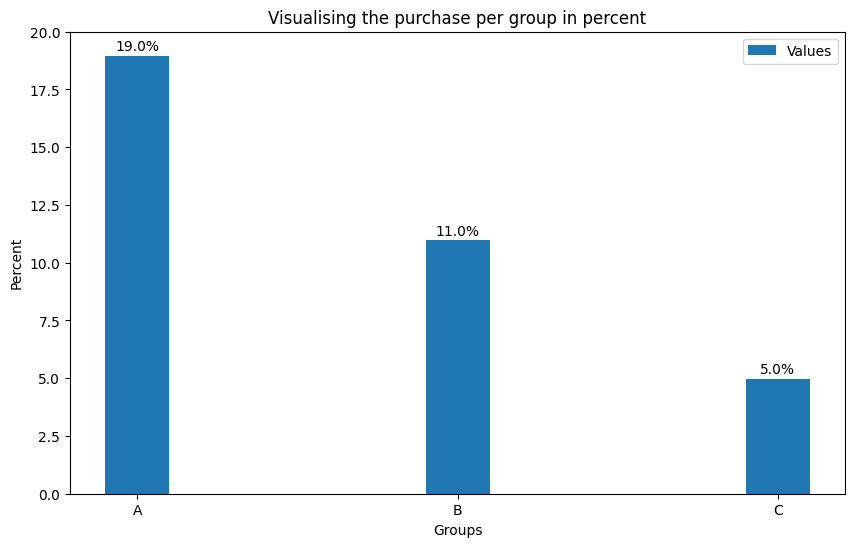

In [9]:
# Setting the plot
fig,ax = plt.subplots(figsize=(10,6))
bars = ax.bar(df.index,df["percent_purchase"].values,width=0.2,align="center",label="Values")

# Loop through the bars and add annotations
for bar in bars:
    height = np.round(bar.get_height())
    ax.annotate(text=f"{height}%",xy=(bar.get_x()+bar.get_width()/2,height),xytext=(0,1),
                textcoords="offset points",ha="center",va="bottom")

# Detailing the plot
ax.set_title("Visualising the purchase per group in percent")
ax.set_xlabel("Groups")
ax.set_yticks(np.arange(0,22.5,2.5))
ax.set_ylabel("Percent")
ax.legend()

# Showing the plot
plt.show()
plt.close(fig=fig)

##### The main objective here is to observe if Grp A ($0.99) price point is significantly greater than the percent of visitors who need to buy an upgrade package at $0.99 in order to make our minimum revenue target of $1,000.

Since we have a sample of categorical data and want to compare to a hypothetical population value a binomial test will be used.

In [10]:
# The number of visitors in grp A and the number of visitors in grpA who made a purchase.
samp_size_099 = int(df.loc[df.index=="A","total"].values[0])
sales_099 = int(df.loc[df.index=="A","Yes"].values[0])
samp_size_199 = int(df.loc[df.index=="B","total"].values[0])
sales_199 = int(df.loc[df.index=="B","Yes"].values[0])
samp_size_499 = int(df.loc[df.index=="C","total"].values[0])
sales_499 = int(df.loc[df.index=="C","Yes"].values[0])

Lets perform a binomial test using `binomtest()` to see if the observed purchase rate is significantly greater than p_sales_needed_099

In [11]:
resultA = binomtest(k=sales_099,n=samp_size_099,p=p_sales_needed_099,alternative="greater")
resultB = binomtest(k=sales_199,n=samp_size_199,p=p_sales_needed_199,alternative="greater")
resultC = binomtest(k=sales_499,n=samp_size_499,p=p_sales_needed_499,alternative="greater")
print("The Binom test result for group A: {}".format(resultA))
print("The Binom test result for group B: {}".format(resultB))
print("The Binom test result for group C: {}".format(resultC))

The Binom test result for group A: BinomTestResult(k=316, n=1666, alternative='greater', statistic=0.18967587034813926, pvalue=0.9028081076188554)
The Binom test result for group B: BinomTestResult(k=183, n=1666, alternative='greater', statistic=0.10984393757503001, pvalue=0.11184562623740596)
The Binom test result for group C: BinomTestResult(k=83, n=1666, alternative='greater', statistic=0.04981992797118848, pvalue=0.027944826659830616)


# Conclusions:
`resultC` is the only p-value below the threshold of 0.05. Therefore, the C group is the only group where we would conclude that the purchase rate is significantly higher than the target needed to reach $1000 revenue per week. Therefore, Brian should charge $4.99 for the upgrade.